# Overview

The heterogeneity of Alzheimer's Disease (AD) across neuropathologies, clinical presentations, and progression trajectories presents significant challenges in establishing standardized diagnostics and developing targeted treatment for diverse patient groups. 

Identification of the neuropathology driving different clinical presentations is made difficult by the fact that the hallmark biomarker in AD diagnosis, amyloid-beta (Aβ), does not differ significantly across the AD variants, including amnestic AD and non-amnestic AD such as those with executive function, language, or visual-spatial impairments. However, with recent advancements in positron emission topography (PET) imaging, tau has been highlighted to agree more with the neurodegeneration patterns underlying different clinical subtypes [1]. 

Yet, despite the increased application of data-driven methods to characterize brain disease heterogeneity in the past decade, a very limited number of studies have involved tau-PET as a modality in clustering. Additionally, the multitude of methods and parameter selections employed in previous studies complicates the validation of robust AD subtypes among studies [2]. Aside from method and modality, existing clinical trials mostly recruit late-onset AD (LOAD) patients with memory deficits, which limits the heterogeneity represented in the study cohorts [3]. 

To address these limitations, this project aims to identify robust AD subtypes based on the topographic distribution of tau by applying robust data-driven clustering methods on baseline tau-PET of sporadic early-onset AD (EOAD) patients from the Longitudinal Early-onset Alzhiermer's Disease Study (LEADS).


In [2]:
# Import libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys 
from matplotlib.lines import Line2D
sys.path.append('../') 

# Data Description

### Study
LEADS is a prospective multisite observational clinical and biomarker study seeking to accomplish comparisons of baseline and longitudinal characteristics of EOAD v.s. LOAD and investigate the contribution of apolipoprotein E (APOE) genotype in EOAD. Similar to the Alzheimer's Disease Neuroimaging Initiative (ADNI), LEADS incorporates longitudinal clinical and cognitive assessments with imaging and biofluid markers to characterize AD holistically. However, the study recruits participants aged 40-64 and does not exclude AD patients with predominantly non-amnesic presentations. 

### Subjects
All Subjects meet the following criteria: age between 40 - 64 when consent, not pregnant or lactating, with no lifetime history of other brain disorder, no prior participation in aβ/tau targeted therapeutic trials, no moderate or severe substance abuse, no suicidal behaviors/ideations in the past 12 mo. 

This project includes 379 Aβ positive sporadic (no autosomal AD mutations) EOAD patients and 89 cognitively normal Aβ negative age-matched controls. A subject is assigned to the EOAD cohort if their amyloid PET has both a positive visual read and a global SUVR >= 1.18. If both are negative then assign to control. In the case of discordance between PET quantification and visual read, an additional reader is assigned to provide a tie-breaking visual read that decides the final assignment of the subject.

### Tau-PET
All subjects undergo MRI scan, 18F-Florbetaben Amyloid PET, and 18F-Flortaucipir Tau PET at baseline. Tau-PET images are co-registered to T1 structural MRI images and normalized with respect to the inferior cerebellar gray to derive standardized uptake value ratio (SUVR) images. The parcellations were performed using the Desikan–Killiany atlas, resulting in segmentation into 72 regions. The parcellations were subsequently combined into ten lobar regions of interest (ROIs) - left and right medial temporal lobe (MTL), parietal lobe, occipital lobe, frontal lobe, and temporal lobe. For each ROI, the volume-weighted mean SUVR was calculated, providing quantitative measures of regional tau distributions. 

# Input preparation  

In [3]:
dat = pd.read_csv('data.csv')
# visit = 1, parc = hemfs_roi - dropped
dat.drop(['visit','roi_full','parc','ftp_date'],axis=1,inplace=True)
dat.head(2)

,subj,dx,roi,suvr,vol
0,LDS0070120,CN,L_amygdala,1.117458,1818
1,LDS0070166,EOAD,L_amygdala,1.933520,1159


In [4]:
## Patient count
for i in dat.dx.unique():
    print(i + ': '+str(len(dat[dat.dx==i].subj.unique())))

CN: 89
EOAD: 379


**ROI Specification** 

ROI definition is a key step in data preprocessing that could impact the result of clustering. The choice to group them into left and right lobar ROI is informed by previous studies highlighting variations in AD pathology across specific lobes, potential hemispheric laterality in AD clinical variants, and the orthogonality of these lobar regions to disease progression in Braak stages IV–VI [5].

**Lobe Mapping**

Following the grouping of Desikan-Kiliany cortical parcellations into lobar regions [4]:

Medial temporal lobe:
entorhinal cortex, parahippocampal gyrus, fusiform gyrus (temporal pole)

Tempoeral lobe:
superior temporal gyrus, middle temporal gyrus, inferior temporal gyrus, transverse temporal gyrus, (bank)

Frontal lobe:
superior frontal gyrus, middle frontal gyrus, inferior frontal gyrus (pars opercularis, pars triangularis, pars orbitalis), orbitofrontal, precentral gyrus, paracentral lobule (frontal pole)

Parietal lobe:
postcentral gyrus, supramarginal gyrus, superior parietal, inferior parietal, percuneus

Occipital lobe:
lingual gyrus, pericalcarine cortex, cuneus cortex, lateral occipital cortex

Cingulate (grouped into the above):
rostral anterior (frontal), caudal anterior (frontal), posterior (parietal), isthmus (parietal)


In [74]:
# create dict to map parcellations to lobar ROI
lobe_dict = {
'L_MTL': ['L_entorhinal','L_amygdala','L_hippocampus' ],
'R_MTL': ['R_entorhinal','R_amygdala','R_hippocampus'],

'L_temporal': ['L_superiortemporal', 'L_middletemporal', 'L_inferiortemporal','L_transversetemporal',
               'L_parahippocampal','L_fusiform'],
'R_temporal': ['R_superiortemporal', 'R_middletemporal','R_inferiortemporal','R_transversetemporal',
               'R_parahippocampal','R_fusiform'],

'L_frontal':['L_superiorfrontal','L_rostralmiddlefrontal','L_caudalmiddlefrontal', #middle frontal gyrus
             'L_parsopercularis', 'L_parsorbitalis', 'L_parstriangularis', #inferior frontal gyrus 
            'L_lateralorbitofrontal','L_medialorbitofrontal', #occipitalfrontal cortex
            'L_rostralanteriorcingulate', 'L_caudalanteriorcingulate',#cingulate
            'L_precentral','L_insula',],
            
'R_frontal':['R_superiorfrontal', 'R_rostralmiddlefrontal', 'R_caudalmiddlefrontal',
             'R_parsopercularis', 'R_parsorbitalis', 'R_parstriangularis',  
             'R_lateralorbitofrontal','R_medialorbitofrontal',
             'R_rostralanteriorcingulate','R_caudalanteriorcingulate', 
              'R_precentral', 'R_insula'], #paracentral?
 
'L_occipital':['L_lateraloccipital','L_lingual','L_cuneus','L_pericalcarine'],
'R_occipital':['R_lateraloccipital','R_lingual','R_cuneus','R_pericalcarine'],

'L_parietal':['L_superiorparietal','L_inferiorparietal','L_supramarginal',
             'L_postcentral','L_precuneus',
             'L_posteriorcingulate','L_isthmuscingulate'],#cingulate
'R_parietal':['R_superiorparietal','R_inferiorparietal','R_supramarginal',
              'R_postcentral','R_precuneus', 
             'R_posteriorcingulate', 'R_isthmuscingulate'],
}
# use this to subset data for correct ordering!
lobes = ['L_MTL', 'R_MTL', 'L_temporal', 'R_temporal', 'L_frontal', 'R_frontal', 
         'L_occipital', 'R_occipital','L_parietal', 'R_parietal' ]
parcellations = dat.roi.unique().tolist()
dat['lobe'] = dat['roi'].apply(lambda roi: next((lobe for lobe, regions in lobe_dict.items() if roi in regions), None))
dat[dat.lobe.isnull()].roi.unique()
dat.sort_values('subj').head(2)

,subj,dx,roi,suvr,vol,lobe
0,LDS0070120,CN,L_amygdala,1.117458,1818,L_MTL
23868,LDS0070120,CN,R_lingual,1.089886,8735,R_occipital


In [6]:
#unassigned parcellated region: 
#banks of the superior temporal sculus (temporal), frontal pole (frontal), paracentral (frontal/parietal?), temporal pole (temporal)
dat[dat.lobe.isnull()].roi.unique()

array(['L_bankssts', 'L_frontalpole', 'L_paracentral', 'L_temporalpole',
       'R_bankssts', 'R_frontalpole', 'R_paracentral', 'R_temporalpole'],
      dtype=object)

## Mean SUVR

In [7]:
## Volume-weighted mean SUVR
wdata = dat.dropna().groupby(['subj', 'dx',  'lobe']).apply(lambda x: np.average(x['suvr'], weights=x['vol'])).reset_index(name='mean_suvr')
wdata.head(2)

,subj,dx,lobe,mean_suvr
0,LDS0070120,CN,L_MTL,1.212698
1,LDS0070120,CN,L_frontal,1.037903


In [8]:
# long to wide  
df = wdata.pivot_table(index=['subj', 'dx'], columns='lobe', values='mean_suvr').reset_index()
df.columns.name = None
cn_idx = df.index[df['dx'] == 'CN']
eoad_idx = df.index[df['dx'] == 'EOAD']
suvr_dat = df.loc[:,lobes].values
df.head(2)


,subj,dx,L_MTL,L_frontal,L_occipital,L_parietal,L_temporal,R_MTL,R_frontal,R_occipital,R_parietal,R_temporal
0,LDS0070120,CN,1.212698,1.037903,1.103603,1.074372,1.127232,1.210549,1.028599,1.109314,1.082730,1.142007
1,LDS0070166,EOAD,1.856240,2.398487,2.957153,3.012157,2.856721,1.695600,2.164095,2.754564,2.877221,2.635381


The input is stored in the wide format where each column represents the mean SUVR of one of the ten lobar ROIs for a subject (to be compatible with the input format for the brainpainter library) The shape of the input is 468 x 10 to begin with. 

## Visualize value distribution

In [9]:
def roi_cluster_violin(data, x, y,roi_name,hue_cat,title_text,labels,strip=True,colors = sns.set_palette('tab20'),**kwargs): 
    #each x gets its own violin. hue splits the violin. each roi get its own plot. 
    #inner: “box”, “quart”, “point”, “stick”,
    # Define the pairs  
    pairs = [
        ('L_MTL', 'R_MTL'),
        ('L_temporal', 'R_temporal'),
        ('L_frontal', 'R_frontal'),
        ('L_occipital', 'R_occipital'),
        ('L_parietal', 'R_parietal')
    ]
    fig, axes = plt.subplots(1,5,figsize=(26,6), sharey = True)#, dpi=480)

    for i, (lobe_l, lobe_r) in enumerate(pairs):
        #row = i // 5
        col = i % 5
        sns.violinplot(data=data[data[roi_name].isin([lobe_l, lobe_r])], x=x, y=y, hue=hue_cat, 
                    split=True,
                    fill=False,
                    ax=axes[col],palette=colors,**kwargs)
        if strip:
            sns.stripplot(data=data[data[roi_name].isin([lobe_l, lobe_r])], 
                      x=x, y=y, hue=hue_cat, 
                    dodge=True,jitter=True, alpha=0.5, size = 4, legend = False,ax=axes[col],palette=colors)#marker='o'

        axes[col].set_title(lobe_l[2:],fontsize=16)
        axes[col].set_xlabel(None)
        axes[col].set_ylabel(None)#lobe_l[2:],fontsize=16)
        axes[col].tick_params(axis='y', labelsize=16)    
        axes[col].tick_params(axis='x', labelsize=16)   

        # Set legend to None for all subplots except the last one
        if i != len(pairs):
            handles, _ = axes[ col].get_legend_handles_labels()
            axes[col].legend().set_visible(False)  

    # Create a single legend in the last subplot
    axes[0].legend(handles, labels, loc='upper left')
    plt.yticks(size=15)
    plt.suptitle(title_text,fontsize=16)
    plt.tight_layout()
    plt.show()


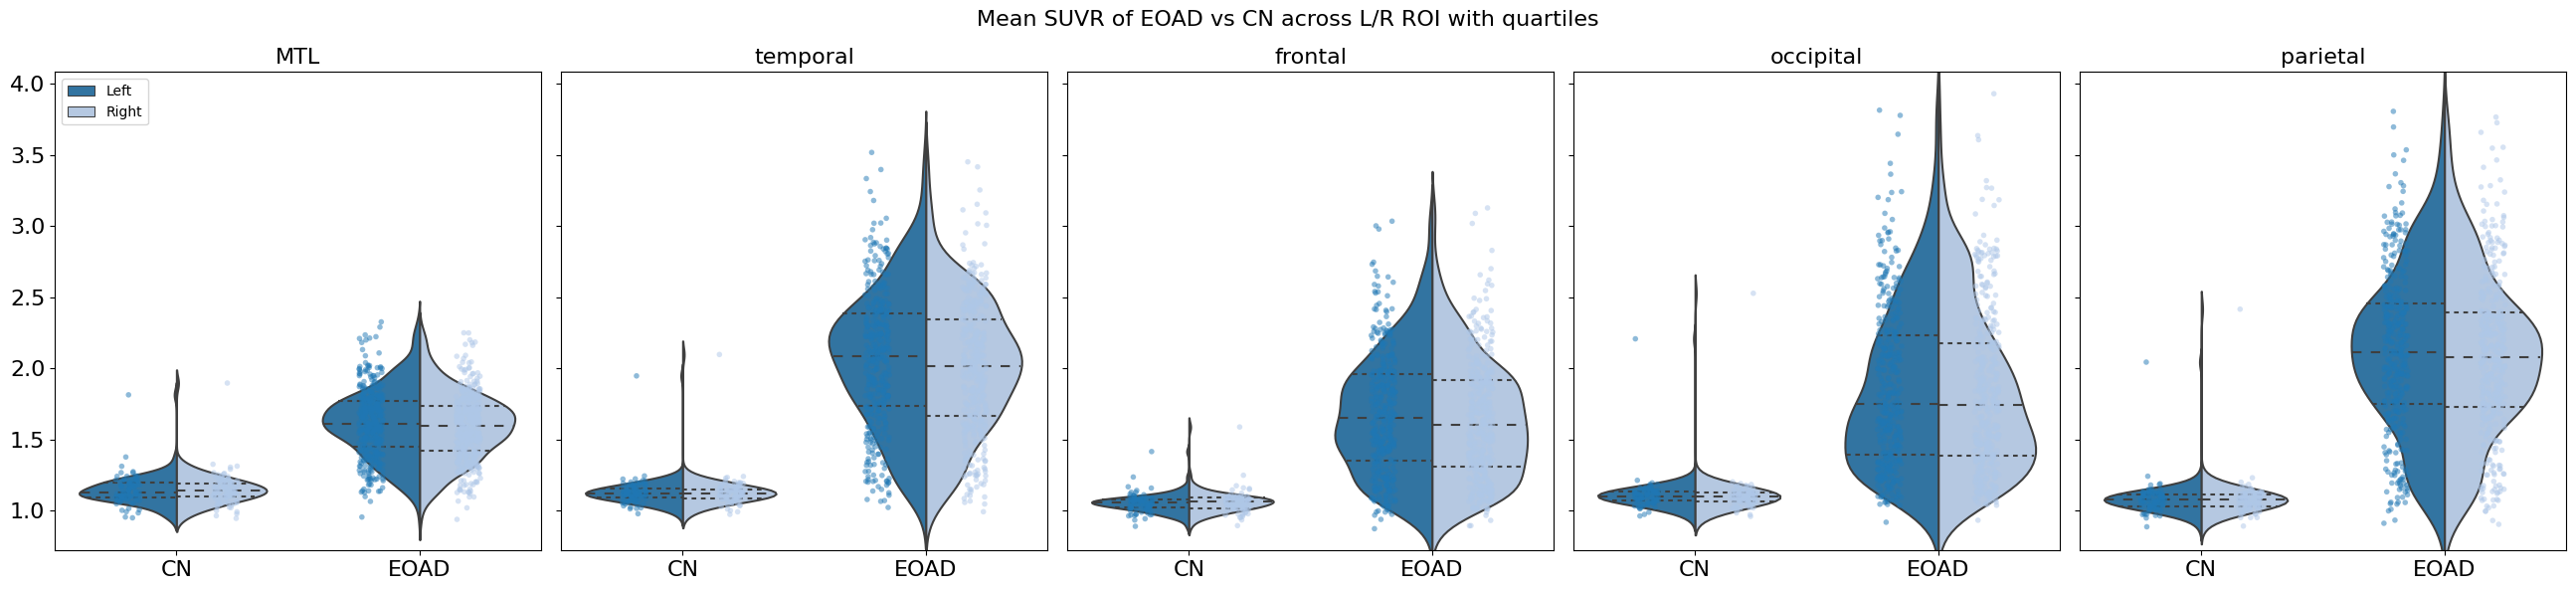

In [10]:
roi_cluster_violin(wdata,
                   x = 'dx',
                   y = 'mean_suvr',
                   roi_name = 'lobe',
                   hue_cat = 'lobe',
                   title_text = 'Mean SUVR of EOAD vs CN across L/R ROI with quartiles',
                   labels = ['Left','Right'],
                   strip = True,
                   colors = sns.set_palette('tab20'),
                   #additional
                   inner='quart')

The grouped violin plots show that the distribution of mean SUVR values is largely symmetrical between the two hemispheres within CN and EOAD respectively, with slightly higher values in the left hemispheres, as indicated by the quartile lines. In the CN group, extreme outliers are present in all ROIs, resulting in long tails in the violin plot. Moreover, the outlier values are higher in the right hemisphere. 

## Standardization

Mean SUVR values are standardized in each region w.r.t. to a normal component derived from Guassian Mixture Model-fit, such that the tau z-scores are informative of the disease stage and the tau dispositions are comparable across the ROIs, and in this case also to eliminate the effects of the extreme outliers observed in CN. (Although looking at the mean SUVR distributions, the values are pretty close in ranges across the ROIs.) 


In [11]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

### Best # of GMM components 


In [12]:
n_components_range = range(1, 6) 
bestk_df = pd.DataFrame(columns=['ROI', 'K', 'AIC']) 
for roi_idx, roi_data in enumerate(suvr_dat.T):  
    cv_aic_scores = [] #
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) #stratified by dx
    for train_index, test_index in kf.split(roi_data,df.dx.values): 
        X_train, X_test = roi_data[train_index], roi_data[test_index]  
        for n_components in n_components_range:
            gmm = GaussianMixture(n_components=n_components, random_state=42)
            gmm.fit(X_train.reshape(-1, 1))  
            means = np.sort(gmm.means_.flatten()) #smaller first
            if n_components == 1 :
                means = [means[0],np.nan] # if it's 1 component set to NaN
            aic_score = gmm.aic(X_test.reshape(-1, 1)) 
            # Store the results for each fold
            fold_results = pd.DataFrame({'ROI': lobes[roi_idx],
                                        'K': n_components,
                                        'AIC': [aic_score],
                                        'mean1':[means[0]],
                                        'mean2':[means[1]]})
            bestk_df = pd.concat([bestk_df, fold_results], ignore_index=True) 
print(bestk_df.shape)#5 components x 10 roi x 5fold = 250 
bestk_df.head(2)


(250, 5)


,ROI,K,AIC,mean1,mean2
0,L_MTL,1,31.843984,1.524820,NaN
1,L_MTL,2,22.608503,1.183449,1.656322


In [13]:
# get best K for each ROI based on lowest mean AIC scores across folds
mean_aic = bestk_df.groupby(['ROI','K']).mean().reset_index()
idx_min = mean_aic.groupby('ROI')['AIC'].idxmin()
bestK = mean_aic.loc[idx_min, ['ROI', 'K']] 
bestK.sort_values('K')

,ROI,K
1,L_MTL,2
6,L_frontal,2
16,L_parietal,2
21,L_temporal,2
26,R_MTL,2
31,R_frontal,2
41,R_parietal,2
46,R_temporal,2
12,L_occipital,3
37,R_occipital,3


/Users/linlin/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray'` for same effect.
  warnings.warn(msg, FutureWarning)


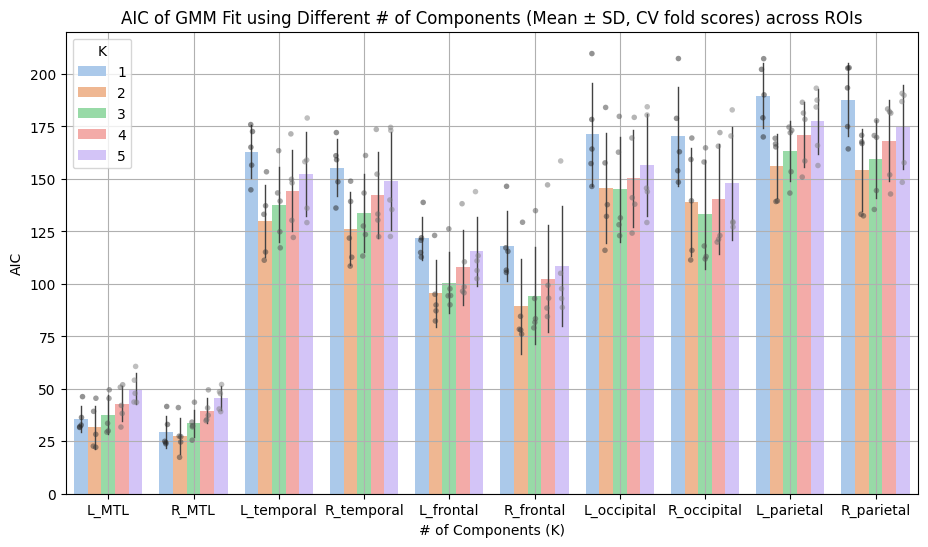

In [14]:
#AIC clustered bar
plt.figure(figsize=(11, 6))
sns.barplot(data=bestk_df, y='AIC', hue='K', x='ROI',   errorbar='sd', errwidth=1, palette=sns.color_palette('pastel')) 
sns.stripplot(data=bestk_df, y='AIC', hue='K', x='ROI', dodge=True, color='gray', alpha=0.5, size=4, legend=False)

plt.xlabel('# of Components (K)')
plt.ylabel('AIC')
plt.title('AIC of GMM Fit using Different # of Components (Mean ± SD, CV fold scores) across ROIs')
plt.legend(title='K')
plt.grid(True)
plt.show() 

For each ROI, a gaussian mixture model is fitted on the mean SUVR data to define a normal component (noise) and a abnormal component. The number of components are decided by cross-validated Akaike information criteria (AIC). In most ROIs, the distribution of mean SUVR follow a 2-GMM, one for normal and the other for abnormal tau levels. The exceptions are the occipital ROIs where 3 components give slightly better fit. 

In [15]:
def plot_mixture(gmm, roi_data, show_legend=True, ax=None):
    sns.set_palette('tab10') 
    if ax is None:
        ax = plt.gca() 
    # Whole mixture
    x = np.linspace(min(roi_data), max(roi_data), 1000)
    logprob = gmm.score_samples(x.reshape(-1, 1))
    pdf = np.exp(logprob) 
    # indiviudal component
    weights = gmm.predict_proba(x.reshape(-1, 1))
    pdf_individual = weights * pdf[:, np.newaxis]  
    # data hist
    ax.hist(roi_data, 30, density=True, histtype='stepfilled',color='gray', alpha=0.4)
    # whole pdf
    ax.plot(x, pdf, '-k', label='Mixture PDF')
    # compoennt pdf
    ax.plot(x, pdf_individual, '--')
    if show_legend:
        ax.legend()


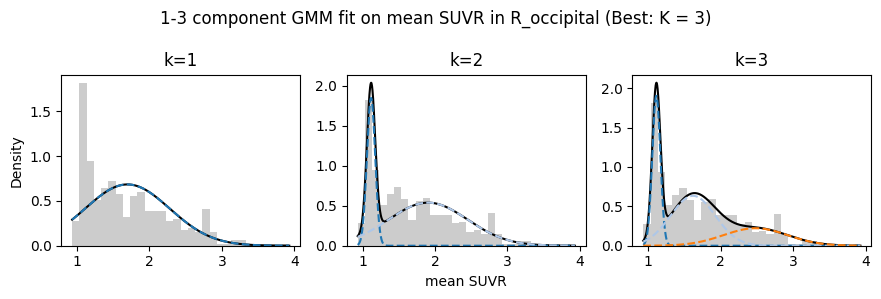

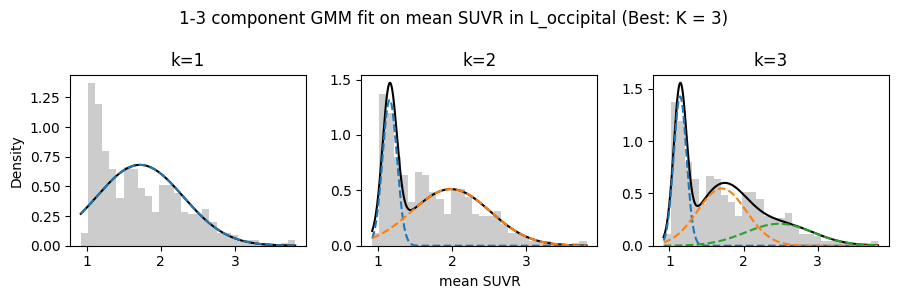

In [16]:
max_c = 3 #max num of component starting from 1
names = ['R_occipital','L_occipital'] # specify roi to plot

for roi in names:
    roi_idx = lobes.index(roi)
    roi_data = suvr_dat[:, roi_idx]   
    roibestk = bestK[bestK.ROI == roi].K.values[0]
    models = [GaussianMixture(n_components=k).fit(roi_data.reshape(-1, 1)) for k in np.arange(max_c) + 1]

    _, axes = plt.subplots(int(np.ceil(max_c/3)), 3, figsize=np.array([3,int(np.ceil(max_c/3))])*3, dpi=100,sharex=True)
    idx = 0
    for gmm, ax in zip(models, axes.ravel()):
        plot_mixture(gmm, roi_data, show_legend=False, ax=ax)
        idx = idx+1
        ax.set_title(f'k={gmm.n_components}')
        plt.suptitle(f'1-3 component GMM fit on mean SUVR in {roi} (Best: K = {roibestk})')
        # to set label
        if idx == 2:
            ax.set_xlabel('mean SUVR')
        if idx == 1:
            ax.set_ylabel('Density')
    
    plt.tight_layout()

### Visualize GMM-fit in each ROI

In [17]:
def annotated_roi_dist(data, roi, stat = 'density',dattype = 'mean SUVR', gmmfit=False, separate=True, annotate=True, cn_include = True,#whether it's gmm fitted, whether separately colored CN and EOAD, whether included CN
                  ax=None, colors=sns.color_palette('tab10'), 
                  rois=lobes, eoad_idx=eoad_idx, cn_idx=cn_idx, dx=df.dx,**kwargs):
    if ax is None:
        _, ax = plt.subplots()
    
    offset = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.01
    roi_data = data[:, rois.index(roi)] 
    if roi == 'L_occipital' or roi == 'R_occipital':
        k = 3
    else:
        k = 2
    roi_df = pd.DataFrame({'roi':roi_data,'dx':dx}) 
    #gmm component or cn/eoad stats?
    if gmmfit:
        colors = sns.color_palette("Accent", 8)
        description = 'for 1st/2nd components'
        # gmm fit
        gmm = GaussianMixture(n_components=k, random_state=42)
        gmm.fit(roi_data.reshape(-1, 1))
        # mean,sd, sorted by first component = smaller mean 
        sorted_idx = np.argsort(gmm.means_.flatten())
        means = np.sort(gmm.means_.flatten())
        stds = np.sqrt(gmm.covariances_.flatten())[sorted_idx]   
        # plot overall pdf
        x = np.linspace(roi_data.min(), roi_data.max(), 1000) 
        pdf = np.exp(gmm.score_samples(x.reshape(-1, 1))) 
        plt.plot(x, pdf, color='black', linestyle='-')  
        # plot component pdf
        weights = gmm.predict_proba(x.reshape(-1, 1))
        pdf_individual = weights * pdf[:, np.newaxis] 
        for i in range(pdf_individual.shape[1]):
            plt.plot(x, pdf_individual[:,i], '--',color=colors[i])
        # plot intersection line
        filter = (x < means[1]) & (x > means[0])
        difference = np.abs(pdf_individual[:, 0][filter]  - pdf_individual[:, 1][filter])#between the means of the 2 components
        intersection = x[filter][np.argmin(difference)]  
        ax.axvline(intersection, color='red', linestyle='--',label='intersection')
        ax.text(intersection+offset, ax.get_ylim()[1]*0.8, f'{intersection:.2f}', color='red', ha='left',fontsize=14)    
    else:
        if cn_include:
            description = 'for CN/EOAD'
            means = [np.mean(roi_data[cn_idx]), np.mean(roi_data[eoad_idx])]
            stds = [np.std(roi_data[cn_idx]), np.std(roi_data[eoad_idx])]
        else:
            description = 'for EOAD only'

    #separately color cn/eoad?
    if separate:
        sns.histplot(roi_df, x='roi', hue='dx', alpha=0.3, stat=stat, multiple='stack',color=colors, ax=ax,**kwargs)
    else:
        sns.histplot(roi_df, x='roi', color='gray', alpha=0.5, stat=stat, multiple='stack', ax=ax,**kwargs)
        
    for i in range(2):
        if annotate:
            ax.axvline(means[i], color=colors[i], linestyle='--')
            ax.axvspan(means[i] - stds[i], means[i] + stds[i], color=colors[i], alpha=0.3)
            if not (gmmfit and i == 0):
                ax.text(means[i] + offset, ax.get_ylim()[1] * 0.96, f'{means[i]:.2f} ± {stds[i]:.2f}', color=colors[i], ha='left',fontsize=14)    
        ax.set_title(f'{roi} (μ±σ {description})')
        ax.set_xlabel(f'{dattype}')
        ax.set_ylabel('Density') 
    return ax



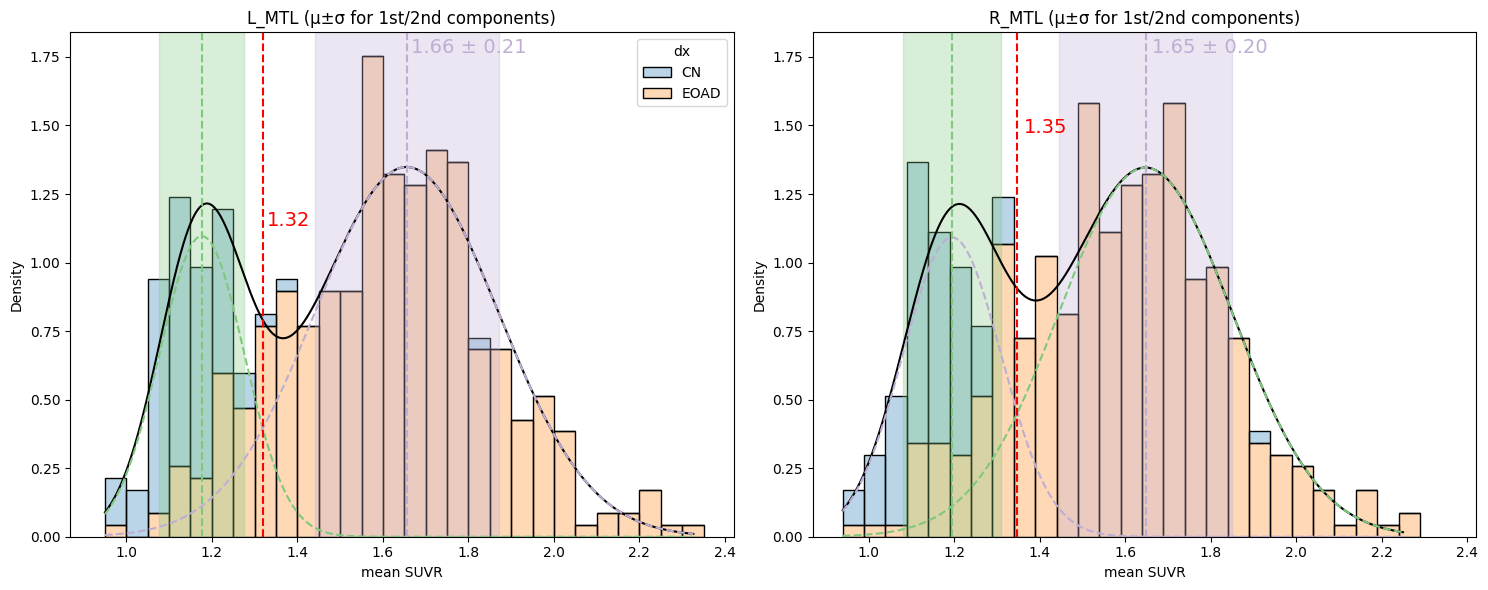

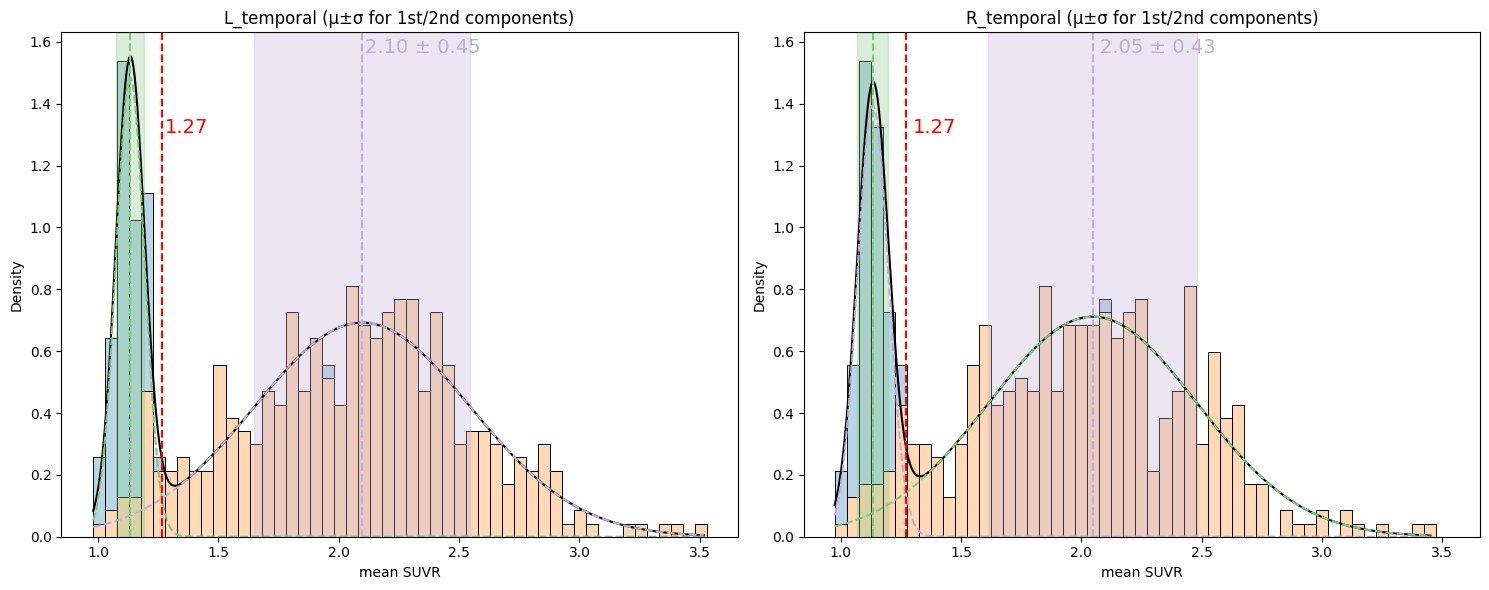

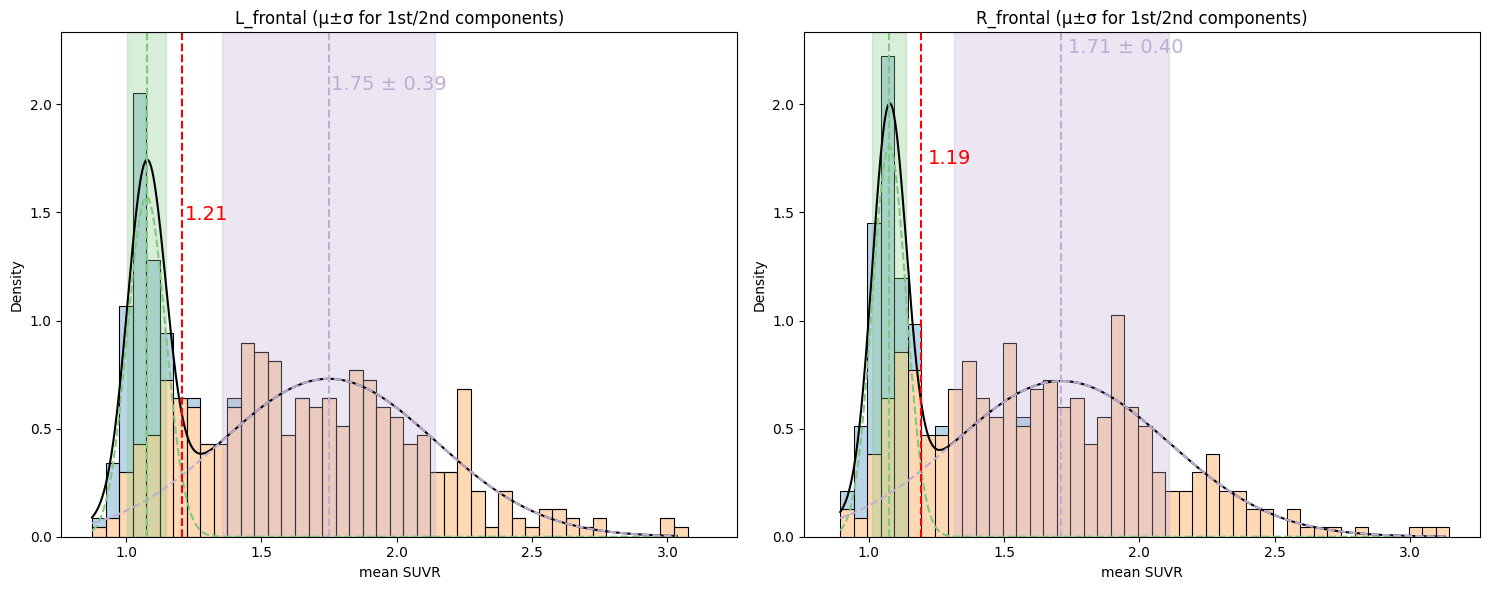

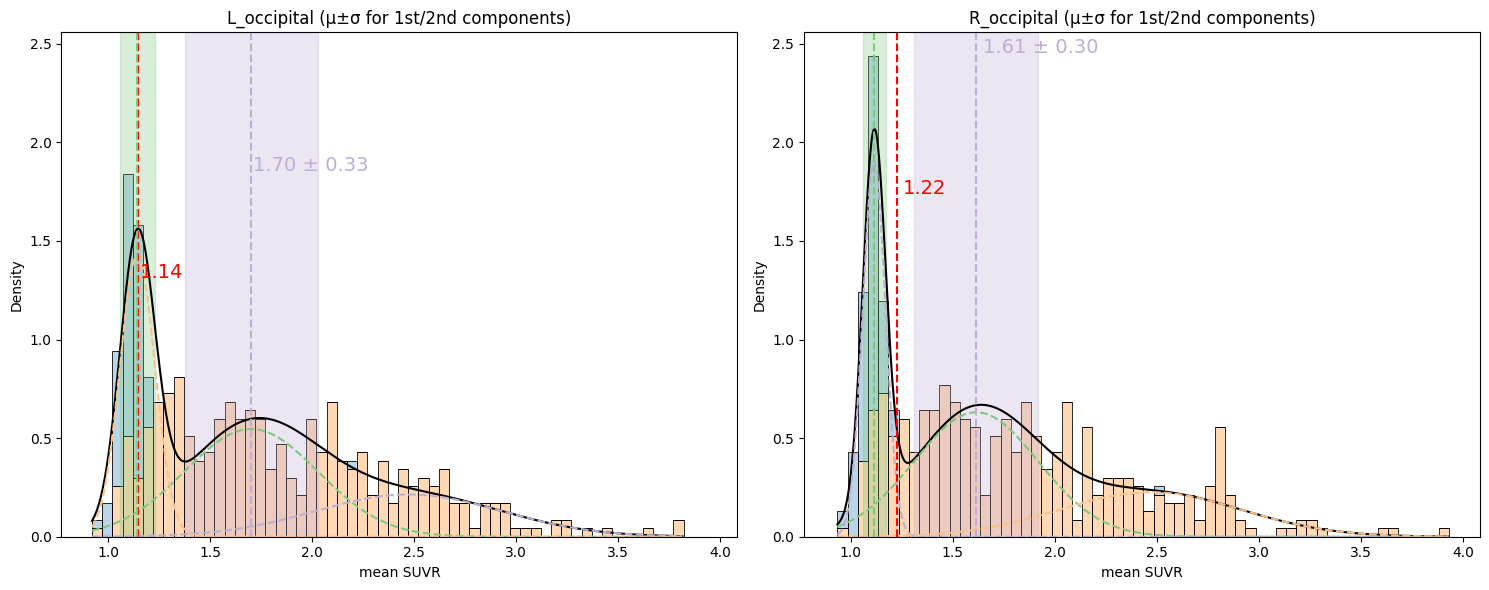

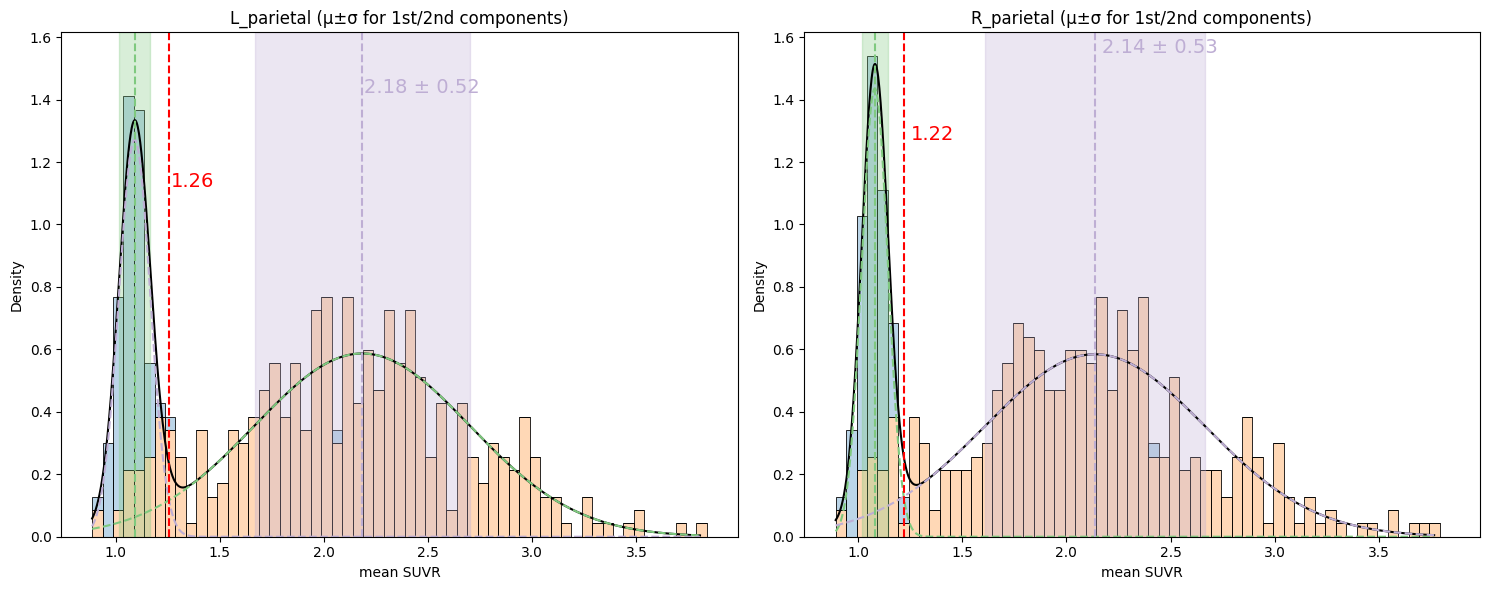

In [18]:

# if share axes for all, for stat = density, sharex for all set to 0, 50, sharey for all set to 0, 0.17
for i in list(range(0,10,2)):
    plt.figure(figsize=(15, 6))
    # Subplot for left
    ax1 = plt.subplot(1, 2, 1)
    annotated_roi_dist(data = suvr_dat, roi=lobes[i], dattype='mean SUVR', gmmfit=True, kde=False, ax = ax1,binwidth=0.05)#,stat='count'
    if i != 0:
        ax1.legend().set_visible(None)

    # Subplot for right
    ax2 = plt.subplot(1, 2, 2,sharex=ax1,sharey=ax1) #add this for same y axis. or sharex
    annotated_roi_dist(data = suvr_dat, roi = lobes[i+1], dattype = 'mean SUVR',gmmfit=True,kde=False, ax=ax2,binwidth=0.05)#stat='count',
    ax2.legend().set_visible(None)

    plt.tight_layout()
    plt.show()


The above figure shows the mean and standard deviation of the first and second component of the mean SUVR values as well as the intersection of the density functions of the two components which could be seen as a ROI-specific abnormality threshold. 

### Standardize w.r.t. 1st component

In [19]:
gmm1mean = []
gmm1std = [] 
gmm_data = suvr_dat.copy()
for roi in lobes:
    roi_idx = lobes.index(roi) 
    k = bestK.loc[bestK.ROI== roi,'K'].values[0]
    gmm_model = GaussianMixture(n_components=k, random_state=42)
    # Fit GMM to the column data/a specific roi
    gmm_model.fit(gmm_data[:, roi_idx].reshape(-1, 1)) 
    # Get the means of the two components
    means = gmm_model.means_.flatten()  
    # sort it by smaller mean = first component
    c1_idx = np.argmin(means)
    std = np.sqrt(gmm_model.covariances_[c1_idx])[0][0]
    mean = means[c1_idx]
    gmm1mean.append(mean)
    gmm1std.append(std)
    #standardize
    gmm_data[:, roi_idx] = (gmm_data[:, roi_idx] - mean)/std


In [20]:
gmm_ctrl = gmm_data[cn_idx]
gmm_eoad = gmm_data[eoad_idx]

# Clustering 
method implementation from sklearn [6] 

The clustering is only performed on EOAD data.

In [21]:
gmm_eoad_df = pd.DataFrame(gmm_eoad,columns = lobes)
gmm_eoad_df.head(2)

,L_MTL,R_MTL,L_temporal,R_temporal,L_frontal,R_frontal,L_occipital,R_occipital,L_parietal,R_parietal
0,6.811265,4.341386,28.987957,23.137703,18.764924,17.270739,21.190565,29.283010,25.424490,28.447762
1,1.526507,0.660932,19.465595,16.764330,9.156001,9.463049,11.091018,13.495515,17.842976,19.441030


## KMeans 

KMeans is a distance-based general-purpose clustering algorithm that assumes all clusters have equal variance and are convex and isotropic. The algorithm aims to minimize the inertia, or within-in-cluster sum-of-squares like the sum of Euclidean distances between points in a cluster to the mean of the cluster, such that the points within the same cluster are as homogenized/coherent as possible. When the dimension of the data is high (in this case we have 10), the distance might be inflated. While Principle Component Analysis or other dimension reduction techniques might solve this problem it also leads to less interpretable clusters because the axes would be principle components instead of the original variables.

KMeans would be fast on the amount of data in this project but the algorithm is sensitive to initializations and the convergence might be to a local minimum only.

The number of clusters needs to be pre-determined and which has a lot of nuisance to it like what metrics are used to optimize. 

In sklearn's implementation, there are 
1. init, which determines how is the cluster centers are initiated. (using)
2. max_iter, max. number of iterations for each run. (using default = 300)
3. tol, if the improvement in metric is below this value it's deemed as convergence. (using default = 1e-4)
4. n_init, the number of times alg is run with different starting centers.

For initalization, again using the default k-means++ which sample different starting centroids based on the empirical probability distribution of the points' distribution to the overall intertia.  

KMeans/KMedians are rarely used in past studies. 

### cluster# determination

Determine by elbow method showing inertia + optimal silhouette score, which is a metric that measures how similar a point is to its cluster (cohesion) than to other clusters (separation). 

The silhouette coefficient for a point is calculated as:

<i>(mean nearest cluster distance - mean intra-cluster distance) / max of the two</i>

where mean nearest cluster distance is the avg. distance between the point and points in the nearest cluster (defined by min. distance between centers) and the mean intra-cluster distance is the avg. distance between the point and other points in the same cluster

The silhouette score is the mean value of all points, ranging from -1 to 1, and a higher silhouette score represents better-defined clusters. 

In [22]:
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [23]:
 
silhouettes = []
inertias = []
ks = range(2, 11)
for n_clusters in ks:
    # Fit KMeans clustering model
    km = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    cluster_labels = km.fit_predict(gmm_eoad)
    
    # Calculate silhouette score
    savg = silhouette_score(gmm_eoad, cluster_labels)
    silhouettes.append(savg)

    # Calculate inertia
    inertia = km.inertia_
    inertias.append(inertia)


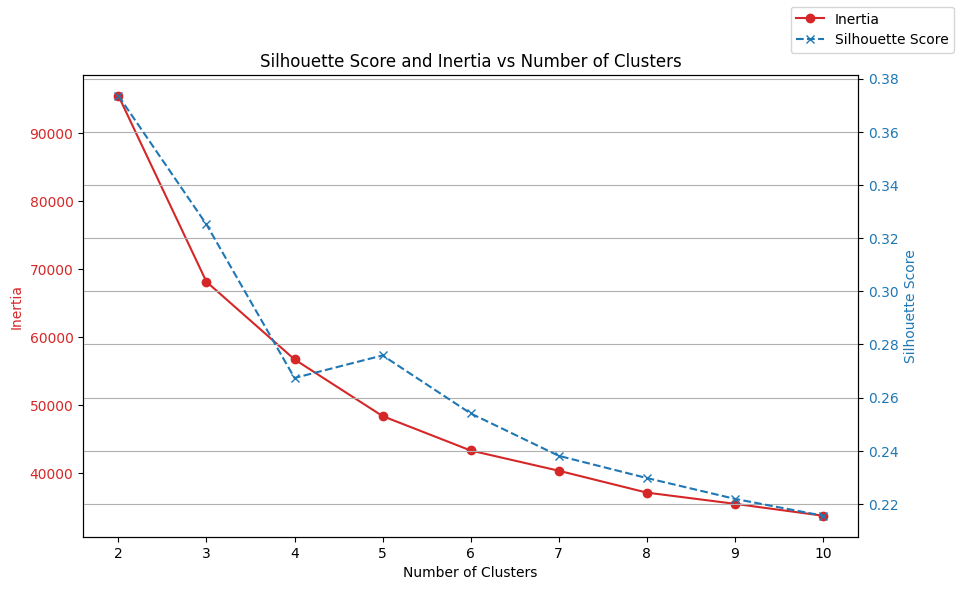

In [24]:
fig, ax1 = plt.subplots(figsize=(10, 6))

#  inertia left axis
color = 'tab:red'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(ks, inertias, marker='o', linestyle='-', color=color, label='Inertia')
ax1.tick_params(axis='y', labelcolor=color)

#  silhouette score right axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(ks, silhouettes, marker='x', linestyle='--', color=color, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color)

fig.legend(loc='upper right')
plt.title('Silhouette Score and Inertia vs Number of Clusters')
plt.grid(True)
plt.show()

While the graph does not show a clear elbow, looking at the silouette score perhaps 5 is a good number. 

For n_clusters = 2 The average silhouette_score is : 0.3735398934204118
For n_clusters = 3 The average silhouette_score is : 0.3251433353738214
For n_clusters = 4 The average silhouette_score is : 0.26739227429584234
For n_clusters = 5 The average silhouette_score is : 0.2758823751604182
For n_clusters = 6 The average silhouette_score is : 0.2540668880561665
For n_clusters = 7 The average silhouette_score is : 0.23812148057856744


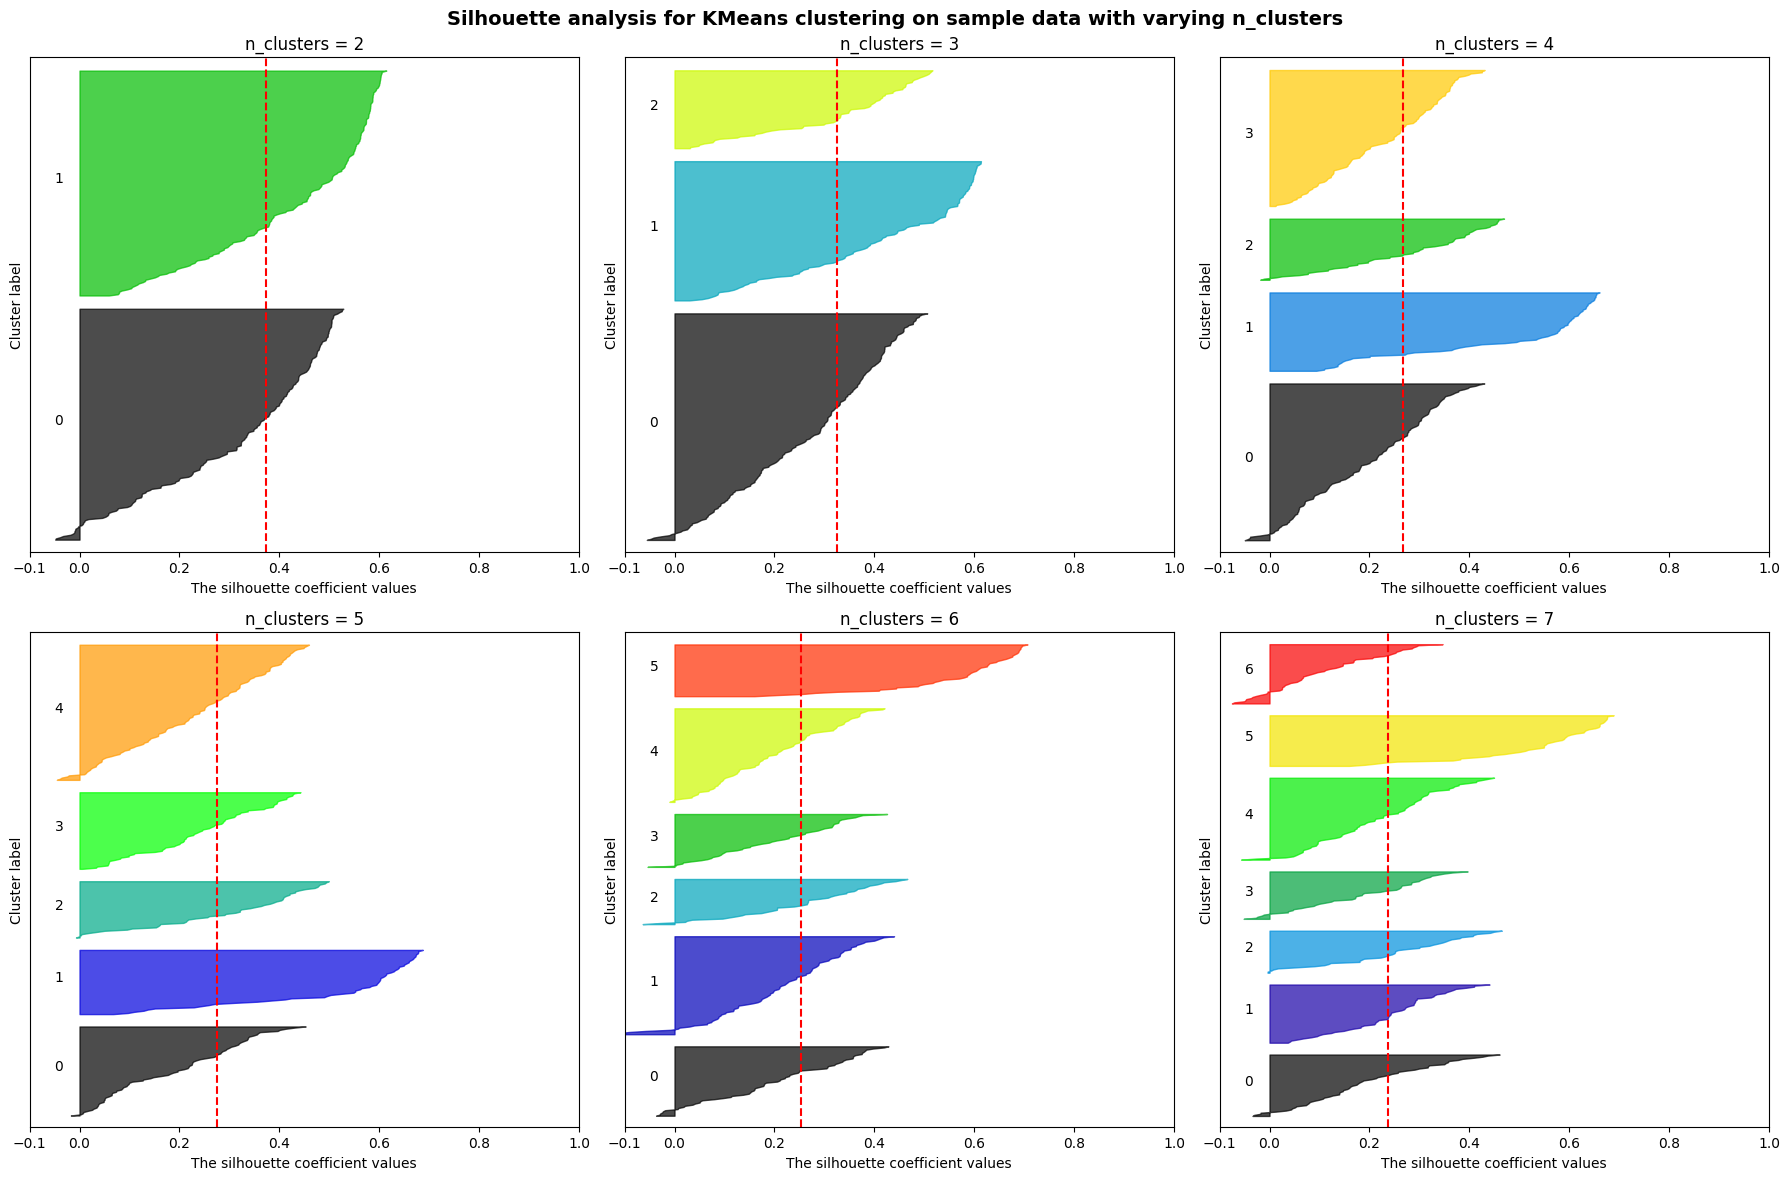

In [25]:
X = gmm_eoad   

range_n_clusters = [2, 3, 4, 5, 6, 7]

fig, axs = plt.subplots(2, 3, figsize=(18, 12))

for idx, n_clusters in enumerate(range_n_clusters):
    row_idx = idx // 3
    col_idx = idx % 3

    ax1 = axs[row_idx, col_idx]
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init = 'auto')
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("n_clusters = {}".format(n_clusters))
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with varying n_clusters",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()


In each of the silhouette plots, all clusters have maximum silhouette scores above the average across the clusters (red dotted line). However, as the number of clusters increases beyond 4 there is a cluster having more data points than the rest which are mostly uniform in size (width of the bar).

### fitting

In [26]:
bestkm = KMeans(n_clusters=5, n_init='auto', random_state=42)
gmm_eoad_df['kmm_lab'] = bestkm.fit(gmm_eoad).labels_

## Hierarchical Clustering

Hierarchical clustering builds a hierarchy of clusters without having a fixed number of clusters, unlike KMeans. The final number is decided by selecting a cut at the hierarchy tree (Dendrogram).

There are two general types of hierarchical clustering:

- Agglomerative: It starts with every data point as a cluster and merges the most similar pairs of data points/clusters until all belong to one cluster.

- Divisive: It starts with a single cluster and recursively splits the clusters into subclusters based on dissimilarity until a single data point is a cluster.

The difference in clusters could be introduced via the distance measure for dissimilarity/similarity and how the cut is decided (this is usually done arbitrarily by combining eyeballing the dendrogram + background knowledge e.g. what number of clusters are interpretable).

The algorithm does not assume equal variance or convex clusters, which allows more flexible cluster shapes. Also, there is no need to pre-specify the number of clusters; the initializations are either agglomerative/divisive. However, it is computationally more complex (especially divisive which is usually implemented as heuristic-bisecting KMeans) can be more sensitive to outliers compared to KMeans.

In sklearn's implementation (for agglomerative), there are: 

1. metric: distance (using default Euclidean)

2. linkage: determines how the clusters are merged together when going up the tree. ward is the most widely used which minimizes the merged cluster variance. other options include: average = average distance among pairs of points from the two clusters to be merged; complete = maximum distances among pairs; single: minimum. (using default ward)

3. distance_threshold and n_clusters: can be None so it computes the full tree till all points are merged into one. or can alternatively specify a threshold/n_clusters (either one, the other is None) beyond which the clusters would not be merged. 


The method (agglomerative hierarchical clustering) is among the most applied in previous studies, perhaps due to the assumption of how tau accumulates in the brain: tau pathology tends to start in certain regions first, and once it reaches a certain level in that region, it spreads to involve other regions. Thus, it is reasonable to think that at each level of the hierarchy, the patients belonging to the same clusters shared similarly affected regions, and the hierarchical structure reflects the progression of tau pathology. Although it is usually left undiscussed how the temporal and spatial heterogeneity are disentangled in this case, that is, two patients belonging to the same cluster could either be a result of them belonging to the same subtype (e.g., trajectories of regions being affected are the same), or them belonging to the same stage (e.g., different trajectories, but both at late stages so most regions are affected - at saturated tau level for most regions).


### cluster# determination


In [27]:
from sklearn.cluster import AgglomerativeClustering
from  scipy.cluster.hierarchy import dendrogram, linkage

In [29]:
agg = AgglomerativeClustering()
agg_lab = agg.fit_predict(gmm_eoad)

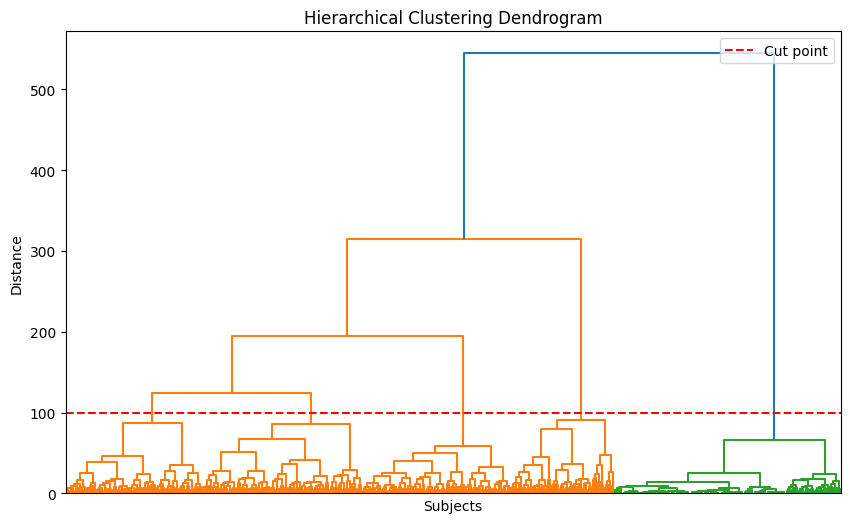

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))

linked = linkage(gmm_data, method='ward')
dendrogram(linked,
           ax=ax,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)

cut_point = 100   
ax.axhline(y=cut_point, color='red', linestyle='--', label='Cut point')
 
ax.set_title('Hierarchical Clustering Dendrogram')
ax.set_xlabel('Subjects')
ax.set_ylabel('Distance')
ax.set_xticks([]) #rm subject labels
ax.legend()
plt.show()


### fitting

In [33]:
bestAgg = AgglomerativeClustering(n_clusters=5) 
gmm_eoad_df['agg_lab'] = bestAgg.fit_predict(gmm_eoad)


## Compare silhouette scores

In [36]:
 
kmeans_silhouette = silhouette_score(gmm_eoad, gmm_eoad_df.kmm_lab)
 
agglomerative_silhouette = silhouette_score(gmm_eoad, gmm_eoad_df.agg_lab)
 
print("Silhouette Score for KMeans clustering:", kmeans_silhouette)
print("Silhouette Score for Agglomerative clustering:", agglomerative_silhouette)


Silhouette Score for KMeans clustering: 0.2758823751604182
Silhouette Score for Agglomerative clustering: 0.23897107412243437


## Cluster visualization 
tau topography, using the brainpainter library https://github.com/razvanmarinescu/brain-coloring 

or https://colab.research.google.com/drive/1qazM2eKGj18eXmu_IVH8HaAWyR9c8IY5#scrollTo=dJVL7DzKNK3Y

In [126]:
suvr_eoad_df = pd.DataFrame(
    data=suvr_dat, columns=lobes
)
suvr_eoad_df['kmm_lab'] = gmm_eoad_df['kmm_lab']
suvr_eoad_df['agg_lab'] = gmm_eoad_df['agg_lab']

In [127]:
#input prep: calculate the mean SUVRs for each ROI  
meltroi = suvr_eoad_df.melt(id_vars = ['kmm_lab','agg_lab'], value_vars = lobes,var_name='ROI',value_name = 'suvr')
melted = meltroi.melt(id_vars = ['ROI','suvr'], value_vars = ['kmm_lab','agg_lab'],var_name='alg',value_name = 'subtype')
means = melted.groupby(['ROI','alg','subtype']).agg(np.mean).reset_index()
means['subtype'] = means['subtype'] + 1
means['alg'] = means['alg'].str[:2]
means['cluster'] = means['alg'] + '_' + means['subtype'].astype(str)
means.drop(['alg','subtype'],axis=1,inplace=True)
means.head(2)

,ROI,suvr,cluster
0,L_MTL,1.568772,ag_1.0
1,L_MTL,1.511257,ag_2.0


In [136]:
#assign the same value to all parcellations belonging to that lobar ROI for coloring
dfs = []
for c in means.cluster.unique():
    rdf = pd.DataFrame(data=np.nan,index=[0],columns=parcellations + ['cluster'])
    rdf['cluster'] = c
    for lobe, par in lobe_dict.items():
        rdf[par] = means[(means['ROI'] == lobe) & (means['cluster'] == c)]['suvr'].iloc[0]
    dfs.append(rdf)
paintdf = pd.concat(dfs)
paintdf = paintdf.dropna(axis=1) #drop not included parcellation
#paintdf.set_index('cluster').reset_index()


In [137]:
# rename to match the DK template in the library
cnames = list(paintdf.columns)[:-1]
paintdf.columns = [n.replace('R_', 'Right-').replace('L_', 'Left-') for n in cnames] + ['Image-name-unique']
# reorder column so image name unique is the first one
paintdf = paintdf[['Image-name-unique']+[n.replace('R_', 'Right-').replace('L_', 'Left-') for n in cnames]]
#paintdf.reset_index(drop=True, inplace=True)
#paintdf[notadded] = 0
paintdf.to_csv('DK_myexperiment.csv',mode = 'w', index=False)
paintdf 



,Image-name-unique,Left-amygdala,Left-caudalanteriorcingulate,Left-caudalmiddlefrontal,Left-cuneus,Left-entorhinal,Left-fusiform,Left-hippocampus,Left-inferiorparietal,Left-inferiortemporal,...,Right-posteriorcingulate,Right-precentral,Right-precuneus,Right-rostralanteriorcingulate,Right-rostralmiddlefrontal,Right-superiorfrontal,Right-superiorparietal,Right-superiortemporal,Right-supramarginal,Right-transversetemporal
0,ag_1.0,1.568772,1.599189,1.599189,1.699427,1.568772,1.934552,1.568772,1.943188,1.934552,...,1.936692,1.575491,1.936692,1.575491,1.575491,1.575491,1.936692,1.901408,1.936692,1.901408
0,ag_2.0,1.511257,1.510695,1.510695,1.674535,1.511257,1.828494,1.511257,1.853926,1.828494,...,1.825638,1.474102,1.825638,1.474102,1.474102,1.474102,1.825638,1.773218,1.825638,1.773218
0,ag_3.0,1.443430,1.508215,1.508215,1.599288,1.443430,1.764720,1.443430,1.786024,1.764720,...,1.743674,1.460125,1.743674,1.460125,1.460125,1.460125,1.743674,1.710483,1.743674,1.710483
0,ag_4.0,1.517451,1.569511,1.569511,1.715817,1.517451,1.847143,1.517451,1.907925,1.847143,...,1.905423,1.552194,1.905423,1.552194,1.552194,1.552194,1.905423,1.835311,1.905423,1.835311
0,ag_5.0,1.598464,1.598770,1.598770,1.818027,1.598464,1.946118,1.598464,2.046344,1.946118,...,2.015627,1.568092,2.015627,1.568092,1.568092,1.568092,2.015627,1.905724,2.015627,1.905724
0,km_1.0,1.509695,1.555006,1.555006,1.629627,1.509695,1.858636,1.509695,1.865069,1.858636,...,1.854680,1.526102,1.854680,1.526102,1.526102,1.526102,1.854680,1.818034,1.854680,1.818034
0,km_2.0,1.583657,1.583159,1.583159,1.785705,1.583657,1.921760,1.583657,1.998851,1.921760,...,1.965613,1.558713,1.965613,1.558713,1.558713,1.558713,1.965613,1.878164,1.965613,1.878164
0,km_3.0,1.520596,1.568092,1.568092,1.653172,1.520596,1.864403,1.520596,1.864662,1.864403,...,1.849487,1.545892,1.849487,1.545892,1.545892,1.545892,1.849487,1.840347,1.849487,1.840347
0,km_4.0,1.494984,1.491111,1.491111,1.652116,1.494984,1.801807,1.494984,1.831310,1.801807,...,1.782145,1.438061,1.782145,1.438061,1.438061,1.438061,1.782145,1.724096,1.782145,1.724096
0,km_5.0,1.534213,1.563726,1.563726,1.754020,1.534213,1.865443,1.534213,1.934443,1.865443,...,1.930100,1.540700,1.930100,1.540700,1.540700,1.540700,1.930100,1.847208,1.930100,1.847208


An example graph showing: for subtype 1 (Above) and 2 (Below) derived from agglomerative clustering, the mean z-score values in different ROI. (ignore above code where the variable is set to suvr)

View: cortical top

Color scale: white -> yellow -> orange -> red 0 -> 1 -> 2 -> 3 -> >3

![Image](DK_output/top_Image_0.png)
![Image](DK_output/top_Image_1.png)

# Next Step(s)

1 Sensitivity analysis w/ varying ROI definition and standardization method

2 Cluster characterization with other clinical/demographic variables 

3 Evaluate other unsuperivsed learning algorithms (e.g., Louvain's method, mixture of experts, latent dirichlet allocation, non-negative matrix factorization among some other popular choices) and COMPARE derived clusters

4 Dimensionality reduction? (t-SNE, UMAP, SOM)

# wide to long. mean. then expand

# Citations
[1] La Joie R, Visani AV, Lesman-Segev OH, Baker SL, Edwards L, Iaccarino L, Soleimani-Meigooni DN, Mellinger T, Janabi M, Miller ZA, Perry DC, Pham J, Strom A, Gorno-Tempini ML, Rosen HJ, Miller BL, Jagust WJ, Rabinovici GD. Association of APOE4 and Clinical Variability in Alzheimer Disease With the Pattern of Tau- and Amyloid-PET. Neurology. 2021 Feb 2;96(5):e650-e661. doi: 10.1212/WNL.0000000000011270. Epub 2020 Dec 1. PMID: 33262228; PMCID: PMC7884991.

[2] Chen P, Zhang S, Zhao K, Kang X, Rittman T, Liu Y. Robustly uncovering the heterogeneity of neurodegenerative disease by using data-driven subtyping in neuroimaging: A review. Brain Res. 2024 Jan 15;1823:148675. doi: 10.1016/j.brainres.2023.148675. Epub 2023 Nov 17. PMID: 37979603.

[3] Apostolova LG, Aisen P, Eloyan A, Fagan A, Fargo KN, Foroud T, Gatsonis C, Grinberg LT, Jack CR Jr, Kramer J, Koeppe R, Kukull WA, Murray ME, Nudelman K, Rumbaugh M, Toga A, Vemuri P, Trullinger A, Iaccarino L, Day GS, Graff-Radford NR, Honig LS, Jones DT, Masdeu J, Mendez M, Musiek E, Onyike CU, Rogalski E, Salloway S, Wolk DA, Wingo TS, Carrillo MC, Dickerson BC, Rabinovici GD; LEADS Consortium. The Longitudinal Early-onset Alzheimer's Disease Study (LEADS): Framework and methodology. Alzheimers Dement. 2021 Dec;17(12):2043-2055. doi: 10.1002/alz.12350. Epub 2021 May 21. PMID: 34018654; PMCID: PMC8939858.

[4] Desikan, R.S., Segonne, F., Fischl, B., Quinn, B.T., Dickerson, B.C., Blacker, D., Buckner, R.L., Dale, A.M., Maguire, R.P., Hyman, B.T., Albert, M.S., Killiany, R.J., 2006. An automated labeling system for subdividing the human cerebral cortex on MRI scans into gyral based regions of interest. Neuroimage 31, 968-980.

[5] Vogel, J.W., Young, A.L., Oxtoby, N.P. et al. Four distinct trajectories of tau deposition identified in Alzheimer’s disease. Nat Med 27, 871–881 (2021). https://doi.org/10.1038/s41591-021-01309-6

[6] Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
 
 